In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [2]:
img_size = 256
batch_size = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/train",
                                                             shuffle= True,
                                                             seed = 42,
                                                             image_size=(img_size,img_size),
                                                             batch_size= batch_size)

Found 322 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Benign', 'Malignant', 'Normal']

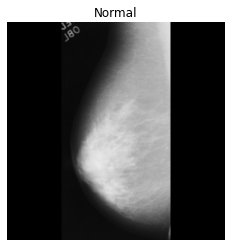

In [5]:
for img_batch, label_batch in dataset.take(1):
    plt.imshow(img_batch[1].numpy().astype("uint8"))
    plt.title(class_name[label_batch[1]])
    plt.axis("Off")

In [6]:
print("Number of batches in a Dataset:", len(dataset))

# Taking 80% of data for training purpose
train_ds = dataset.take(round(len(dataset)* 0.8))

# Skipping 80% of training data and Taking remaining 20% of data for Validation and Test
val_n_test = dataset.skip(round(len(dataset)*0.8))

# Taking 10% of data from val_n_test for validation and another 10% for test data
val_ds = val_n_test.take(round(len(val_n_test)*0.5))
test_ds = val_n_test.skip(round(len(val_n_test)*0.5))

print("Train Dataset:",len(train_ds))
print()
print("Number of batches selected for test and validation:", len(val_n_test))
print("Validation Dataset:",len(val_ds))
print("Test Dataset:", len(test_ds))

Number of batches in a Dataset: 11
Train Dataset: 9

Number of batches selected for test and validation: 2
Validation Dataset: 1
Test Dataset: 1


In [7]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 18s 542ms/step - loss: 2.9275 - accuracy: 0.5000 - val_loss: 1.9456 - val_accuracy: 0.6250
Epoch 2/20
9/9 [==============================] - 4s 407ms/step - loss: 1.3222 - accuracy: 0.4618 - val_loss: 1.2734 - val_accuracy: 0.6562
Epoch 3/20
9/9 [==============================] - 4s 410ms/step - loss: 1.0380 - accuracy: 0.5312 - val_loss: 0.8936 - val_accuracy: 0.7188
Epoch 4/20
9/9 [==============================] - 4s 408ms/step - loss: 0.9379 - accuracy: 0.6493 - val_loss: 0.7920 - val_accuracy: 0.6562
Epoch 5/20
9/9 [==============================] - 4s 415ms/step - loss: 0.7885 - accuracy: 0.6667 - val_loss: 0.6853 - val_accuracy: 0.7500
Epoch 6/20
9/9 [==============================] - 4s 407ms/step - loss: 0.7643 - accuracy: 0.6875 - val_loss: 0.7400 - val_accuracy: 0.7188
Epoch 7/20
9/9 [==============================] - 4s 413ms/step - loss: 0.6921 - accuracy: 0.7257 - val_loss: 0.9368 - val_accuracy: 0.5312
Epoch 8/20
9/9 [==============

In [8]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.8410 - accuracy: 0.5000


In [9]:
scores

[0.8410434722900391, 0.5]

In [10]:
history.params

{'epochs': 20, 'steps': 9, 'verbose': 1}

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [12]:
loss = history.history["loss"]
acc = history.history["accuracy"]

val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

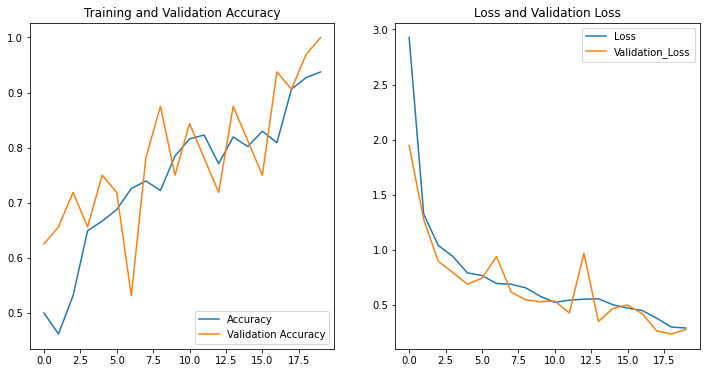

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label="Accuracy")
plt.plot(range(20), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(20), loss, label="Loss")
plt.plot(range(20), val_loss,label="Validation_Loss")
plt.legend(loc="upper right")
plt.title("Loss and Validation Loss")
plt.show()

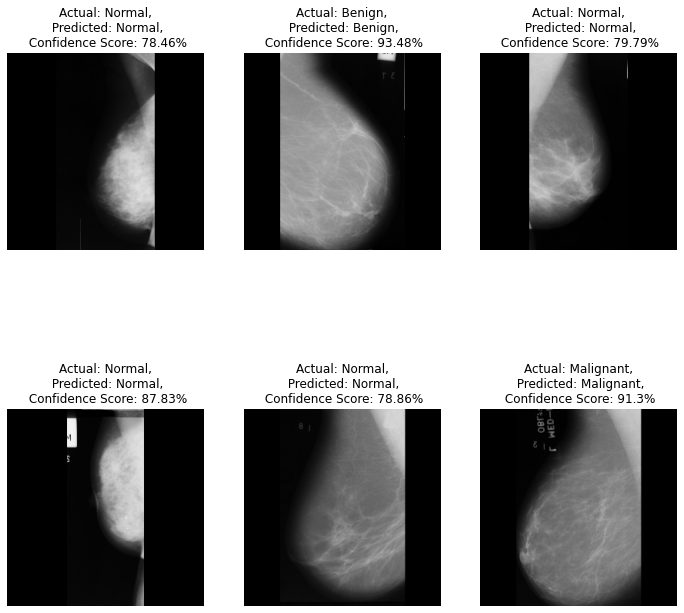

In [14]:
BATCH_SIZE = 6
plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
   for i in range(BATCH_SIZE):
      ax = plt.subplot(2, 3, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      actual_cls = class_name[labels[i]]
      prediction = model.predict(images)
      predicted_cls = class_name[np.argmax(prediction[i])]
      confidence = round(100 * (np.max(prediction[i])), 2)
      plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
      plt.axis("off")

In [15]:
model.save("breastcancer_resnet50.h5")

In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("\nTestAccuracy:", test_acc)

1/1 - 1s - loss: 0.1438 - accuracy: 1.0000 - 937ms/epoch - 937ms/step

TestAccuracy: 1.0


In [17]:
new_model = keras.models.load_model("/content/breastcancer_resnet50.h5")


Normal
0.88


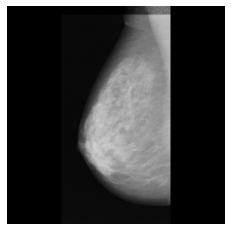

In [18]:
for img,label in test_ds.take(1):
  prediction = model.predict(img)
  print(class_name[np.argmax(prediction[0])])
  print(round(np.max(prediction[0]),2))
  plt.imshow(img[0].numpy().astype("uint8"))
  plt.axis("off")
  break